<a href="https://colab.research.google.com/github/sudheervobili/Pytorch/blob/main/optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
# Upload kaggle.json
from google.colab import files
files.upload()  # Select Kaggle (3).json

# Configure Kaggle CLI
!mkdir -p ~/.kaggle
!cp "Kaggle (3).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle CLI
!pip install -q kaggle

# Download Dataset
!kaggle datasets download hojjatk/mnist-dataset

# Unzip Dataset
!unzip mnist-dataset.zip


Saving Kaggle (3).json to Kaggle (3).json
Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
  0% 0.00/22.0M [00:00<?, ?B/s]
100% 22.0M/22.0M [00:00<00:00, 1.31GB/s]
Archive:  mnist-dataset.zip
  inflating: t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: t10k-images.idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: t10k-labels.idx1-ubyte  
  inflating: train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: train-images.idx3-ubyte  
  inflating: train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: train-labels.idx1-ubyte  


In [7]:
!pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=32ef5ffad322b92ec57b758e3c5f357d5caa4d0bc39afba3bb248f5b2fbc7253
  Stored in directory: /root/.cache/pip/wheels/87/e5/e7/70fc742b3645ddf9d392f766feccbcc95cb3a3c806f8588af0
Successfully built idx2numpy


In [8]:
import idx2numpy


# Load training images and labels
train_images = idx2numpy.convert_from_file('/content/train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file('/content/train-labels.idx1-ubyte')

# Flatten images (28x28 → 784)
train_images_flat = train_images.reshape(train_images.shape[0], -1)

print(train_images_flat.shape)  # (60000, 784)
print(train_labels.shape)       # (60000,)


(60000, 784)
(60000,)


In [9]:
# Convert to pandas DataFrame
df = pd.DataFrame(train_images_flat)

# Add label column at front
df.insert(0, 'label', train_labels)

print(df.head())


   label  0  1  2  3  4  5  6  7  8  ...  774  775  776  777  778  779  780  \
0      5  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
1      0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
2      4  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
3      1  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
4      9  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   

   781  782  783  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0  

[5 rows x 785 columns]


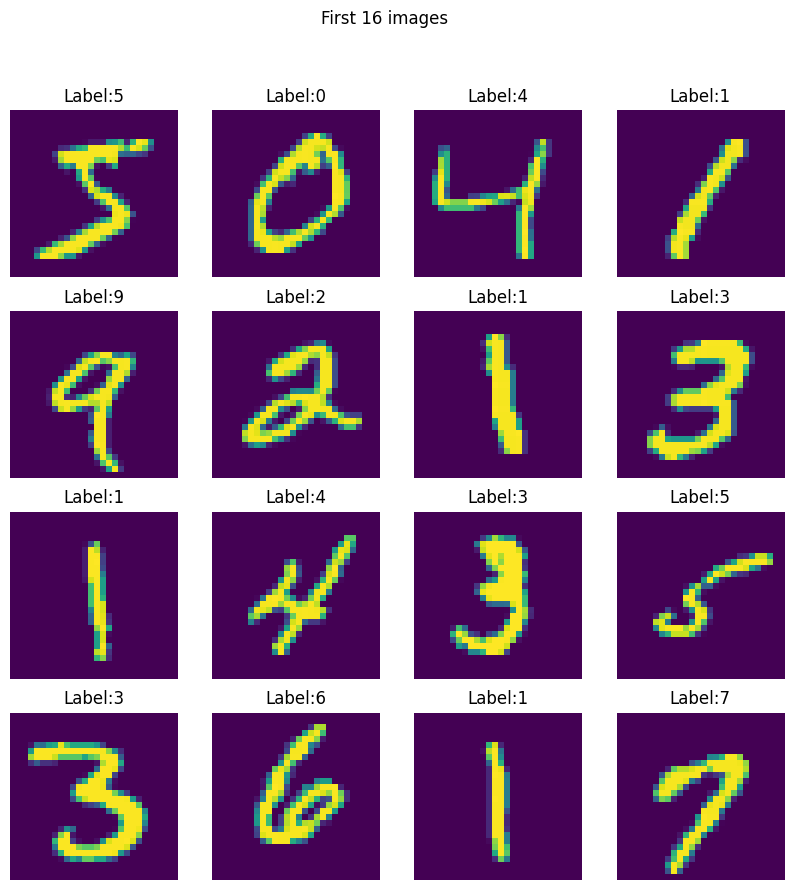

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 images")
for i, ax in enumerate(axes.flat):
   img = df.iloc[i, 1:].values.reshape(28, 28)
   ax.imshow(img)
   ax.axis('off')
   ax.set_title(f"Label:{df.iloc[i, 0]}")
plt.show()

In [11]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [13]:
X_train = X_train/255.0
X_test = X_test/255.0

In [14]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)  # Changed here
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]


In [15]:
train_dataset = CustomDataset(X_train,y_train)
test_dataset = CustomDataset(X_test,y_test)

In [16]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=2,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False,num_workers=2,pin_memory=True)

In [25]:
class MyNN(nn.Module):
  def __init__(self,input_dim,output_dim,num_hidden_layers,neurons_per_layer):
    super().__init__()
    layers = []
    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim,neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(0.3))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer,output_dim))
    self.model = nn.Sequential(*layers)
  def forward(self,x):
    return self.model(x)


In [29]:
#import optuna
import torch
import torch.nn as nn
import torch.optim as optim

def objective(trial):
    # Hyperparameter suggestions
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
    neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    epochs = trial.suggest_int("epochs", 10, 100)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-1, log=True)
    #momentum = trial.suggest_float("momentum", 0.0, 0.99, step=0.01)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Model initialization
    input_dim = 784
    output_dim = 10
    model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer)
    model = model.to(device)

    criterian = nn.CrossEntropyLoss()

    # Optimizer selection
    optimizer_class = getattr(optim, optimizer_name)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch_features, batch_labels in train_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            loss = criterian(outputs, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation (Test Accuracy)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total  # ✅ OUTSIDE the loop

    return accuracy


In [27]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 4.1 MB/s eta 0:00:00


In [30]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-07-08 07:11:34,748] A new study created in memory with name: no-name-c5ca9706-6b18-43fe-b775-33f9baac612e
[I 2025-07-08 07:15:06,950] Trial 0 finished with value: 0.9695 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 56, 'learning_rate': 0.016686970049104154, 'optimizer': 'SGD', 'epochs': 48, 'batch_size': 64, 'weight_decay': 3.590753590282247e-06}. Best is trial 0 with value: 0.9695.
[W 2025-07-08 07:16:39,369] Trial 1 failed with parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 48, 'learning_rate': 0.0015704769552665452, 'optimizer': 'Adam', 'epochs': 91, 'batch_size': 64, 'weight_decay': 0.001356863507610575} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-29-1175263115.py", line 40, in objective
    outputs = model(batc

KeyboardInterrupt: 